# Visual Analysis

This notebook has been created to support two main purposes:
* Based on an input image and a set of models, display the action-space probability distribution.
* Based on an input image and a set of models, visualize which parts of the image the model looks at.

## Usage

The workbook requires the following:
* A set of raw images captured from the front camera of the car
* One or more static model files (`model_*.pb`)
* The `model_metadata.json`

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

This workbook will require `tensorflow` and `cv2` to work.

## Imports

Run the imports block below:

In [1]:
import json
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.io.gfile import GFile

import visualization
from visualization import load_session, visualize_gradcam_discrete_ppo, rgb2gray

2023-10-26 14:10:56.576432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 14:10:56.576500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 14:10:56.576517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 14:10:56.584950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
import importlib
importlib.reload(visualization)

<module 'visualization' from '/mnt/e/sai/Deepracer/dr-rogue-generalization/analysis/visualization.py'>

## Configure and load files

Provide the paths where the image and models are stored. Also define which iterations you would like to review.

In [3]:
img_selection = '../images/reInvent2019_wide/cw/*.jpeg'
model_path = '../models/rogue-2018W-C12-1-3-DC-MM-FINAL-NYC-COPY-2-model'
iterations = [1]

Load the model metadata in, and define which sensor is in use.

In [4]:
with open("{}/model_metadata.json".format(model_path),"r") as jsonin:
    model_metadata=json.load(jsonin)
my_sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
display(model_metadata)

{'action_space': [{'steering_angle': -16, 'speed': 2.18, 'index': 0},
  {'steering_angle': -13.5, 'speed': 1.5, 'index': 1},
  {'steering_angle': 0.1, 'speed': 3.4, 'index': 2},
  {'steering_angle': -3, 'speed': 2.7, 'index': 3},
  {'steering_angle': -13.8, 'speed': 1.76, 'index': 4},
  {'steering_angle': 11, 'speed': 2, 'index': 5},
  {'steering_angle': 0.1, 'speed': 3.5, 'index': 6},
  {'steering_angle': 5, 'speed': 3.35, 'index': 7},
  {'steering_angle': -5.2, 'speed': 2.89, 'index': 8},
  {'steering_angle': -28, 'speed': 0.9, 'index': 9}],
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '5',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'discrete',
 'preprocess_type': 'GREY_SCALE',
 'regional_parameters': ['0', '0', '0', '0']}

Load in the pictures from the pre-defined path.

In [5]:
picture_files = sorted(glob.glob(img_selection))
picture_files = picture_files[1:5]
display(picture_files)

['../images/reInvent2019_wide/cw/11.jpeg',
 '../images/reInvent2019_wide/cw/12.jpeg',
 '../images/reInvent2019_wide/cw/13.jpeg',
 '../images/reInvent2019_wide/cw/14.jpeg']

In [6]:
action_names = []
degree_sign= u'\N{DEGREE SIGN}'
for action in model_metadata['action_space']:
    action_names.append(str(action['steering_angle'])+ degree_sign + " "+"%.1f"%action["speed"])
display(action_names)

['-16° 2.2',
 '-13.5° 1.5',
 '0.1° 3.4',
 '-3° 2.7',
 '-13.8° 1.8',
 '11° 2.0',
 '0.1° 3.5',
 '5° 3.4',
 '-5.2° 2.9',
 '-28° 0.9']

## Load the model files and process pictures
We will now load in the models and process the pictures. Output is a nested list with size `n` models as the outer and `m` picture as the inner list. The inner list will contain a number of values equal to the 

In [7]:
model_inference = []
models_file_path = []

for n in iterations:
    models_file_path.append("{}/agent/model.pb".format(model_path,n))
display(models_file_path)

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file, my_sensor)
    arr = []
    for f in picture_files[:]:
        img = cv2.imread(f)
        img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

['../models/rogue-2018W-C12-1-3-DC-MM-FINAL-NYC-COPY-2-model/agent/model.pb']

2023-10-26 14:11:54.232574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:11:54.296779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:11:54.296856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



2023-10-26 14:11:54.978394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:11:54.978473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:11:54.978481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1977] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-10-26 14:11:54.978514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:11:54.978533: I tensorflow/core/common_runtime/gpu/gpu_device.c

load graph: ../models/rogue-2018W-C12-1-3-DC-MM-FINAL-NYC-COPY-2-model/agent/model.pb


2023-10-26 14:11:55.342945: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-10-26 14:11:55.343418: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:11:55.343454: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:11:55.343460: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:11:55.343464: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:11:55.343467: I tensorflow/core/com

main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/BatchnormActivationDropout_1_activation: (Relu): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/k

2023-10-26 14:12:03.646568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-26 14:12:16.707905: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-26 14:12:19.307728: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Simulation Image Analysis - Probability distribution on decisions (actions)

We will now show the probabilities per action for the selected picture and iterations. The higher the probability of one single action the more mature is the model. Comparing different models enables the developer to see how the model is becoming more certain over time.

In [8]:
PICTURE_INDEX=0
display(picture_files[PICTURE_INDEX])

'../images/reInvent2019_wide/cw/11.jpeg'

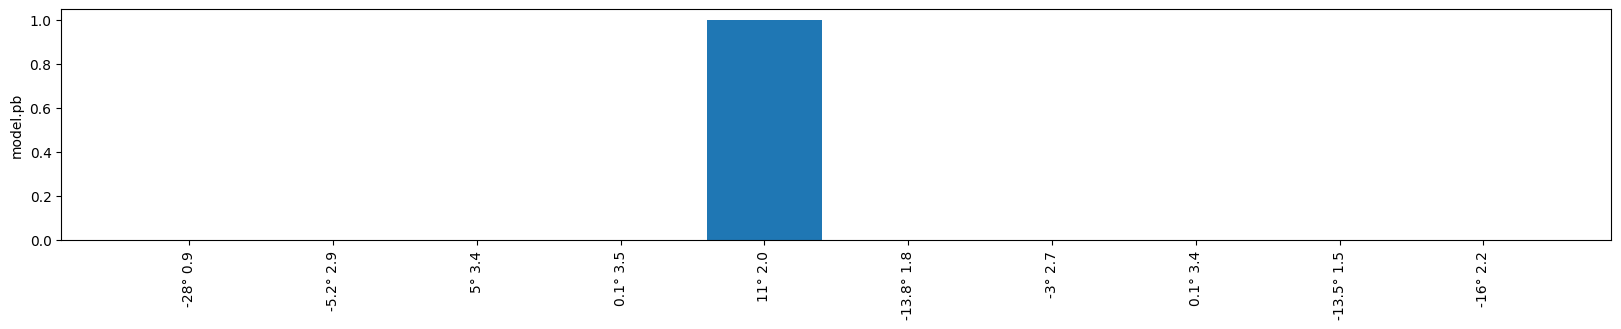

In [9]:
x = list(range(1,len(action_names)+1))

num_plots = len(iterations)
fig, ax = plt.subplots(num_plots,1,figsize=(20,3*num_plots),sharex=True,squeeze=False)

for p in range(0, num_plots):
    ax[p][0].bar(x,model_inference[p][PICTURE_INDEX][::-1])
    plt.setp(ax[p, 0], ylabel=os.path.basename(models_file_path[p]))
    
plt.xticks(x,action_names[::-1],rotation='vertical')
plt.show()

In [68]:
picture_files = picture_files[0:1]
picture_files

['../images/reInvent2019_wide/cw/11.jpeg']

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [11]:
img = cv2.imread(picture_files[0])
img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
img_arr = np.array(img)
img_arr = rgb2gray(img_arr)
img_arr = np.expand_dims(img_arr, axis=2)

sess, obs, model_out = load_session(model_file, my_sensor)
x = obs
feed_dict = {x: [img_arr]}

conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(my_sensor))
output = sess.run(conv_output, feed_dict=feed_dict)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



2023-10-26 14:16:53.753515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:16:53.753988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:16:53.754025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:16:53.803917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 14:16:53.803974: I tensorflow/core/co

load graph: ../models/rogue-2018W-C12-1-3-DC-MM-FINAL-NYC-COPY-2-model/agent/model.pb


2023-10-26 14:16:54.480213: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:16:54.480412: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:16:54.480423: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:16:54.480427: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 14:16:54.480431: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

ob:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/mul_1/y: (Pack): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/add: (Add): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/strided_slice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/n

In [55]:
conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(my_sensor))
final_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
last_conv_layer_output, preds = sess.run([conv_output, final_output], feed_dict=feed_dict)
last_conv_layer_output, preds

(array([[[[-0.3666009 , -0.637722  , -0.03407837, ..., -0.12663858,
           -0.21819335, -0.11583924],
          [-0.36601773, -0.63434476, -0.03093772, ..., -0.1256457 ,
           -0.22257677, -0.11146063],
          [-0.37119886, -0.6366079 , -0.03547036, ..., -0.13105063,
           -0.22651987, -0.11130814],
          ...,
          [-0.37050414, -0.66884464,  0.00360027, ..., -0.09645249,
           -0.20163533, -0.0766321 ],
          [-0.33472362, -0.6556334 ,  0.03421073, ..., -0.09359577,
           -0.23188075, -0.05060016],
          [-0.36149326, -0.63840836, -0.01028136, ..., -0.10935076,
           -0.23319905, -0.07689622]],
 
         [[-0.6740724 , -0.6483467 , -0.14336412, ..., -0.44807568,
           -0.27945665, -0.04186312],
          [-0.7098112 , -0.62909925, -0.14598489, ..., -0.48730242,
           -0.28302988, -0.08956137],
          [-0.7262355 , -0.61361516, -0.1536423 , ..., -0.4717224 ,
           -0.27100545, -0.13528223],
          ...,
          [-0

In [27]:
img = cv2.imread(picture_files[0])
img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
img_arr = np.array(img)
img_arr = rgb2gray(img_arr)
img_arr = np.expand_dims(img_arr, axis=2)

sess, obs, model_out = load_session(model_file, my_sensor)
x = obs
feed_dict = {x: [img_arr]}
conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(my_sensor))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6

load graph: ../models/rogue-2018W-C12-1-3-DC-MM-FINAL-NYC-COPY-2-model/agent/model.pb


2023-10-26 15:04:23.891956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 15:04:23.892037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 15:04:23.892062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 15:04:23.892610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 15:04:23.892640: I tensorflow/core/co

In [63]:
loss = tf.multiply(model_out, tf.one_hot([category_index], len(action_names)))
reduced_loss = tf.reduce_sum(loss[0])
grads1 = tf.gradients(reduced_loss, conv_output)[0]
output1, grads_val1 = sess.run([conv_output, grads1], feed_dict=feed_dict)

2023-10-26 15:54:24.178630: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:24.178681: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:24.178688: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:24.178691: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:24.178694: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

b:localhost/replica:0/task:0/device:GPU:0
strided_slice_18/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_18/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_19/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_19/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_19/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/grad_ys_0/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/strided_slice_19_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/strided_slice_19_grad/StridedSliceGrad/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/strided_slice_19_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/strided_slice_19_grad/StridedSliceGrad/end: (Const): /job:localhost/repli

In [64]:
grads2 = tf.gradients(model_out[0][category_index], conv_output)[0]
output2, grads_val2 = sess.run([conv_output, grads2], feed_dict=feed_dict)

2023-10-26 15:54:31.670744: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:31.670797: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:31.670803: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:31.670806: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:54:31.670809: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

in_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_8/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING

In [28]:
y_output = sess.run(model_out, feed_dict={x:[img_arr]})[0]
category_index = np.argmax(y_output)
grads = tf.gradients(model_out[0][category_index], conv_output)

1/FRONT_FACING_CAMERA/Flatten/flatten/strided_slice/stack_5: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Flatten/flatten/strided_slice/stack_1_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Flatten/flatten/strided_slice/stack_2_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Flatten/flatten/Reshape/shape/1_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/middleware_fc_embedder/Dense_0/kernel_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/middleware_fc_embedder/Dense_0/bias_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/gradients_from_head_0-0_rescalers_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/netw

2023-10-26 15:04:24.715388: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:24.715422: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:24.715428: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:24.715431: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:24.715434: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

In [29]:
output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
weights = np.mean(grads_val, axis=(1, 2))
cam = np.sum(weights * output, axis=3)
cam = np.maximum(cam, 0)

2023-10-26 15:04:25.932153: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:25.932207: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:25.932213: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:25.932216: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-26 15:04:25.932219: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

ob:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/kernel_4: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/bias_4: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_

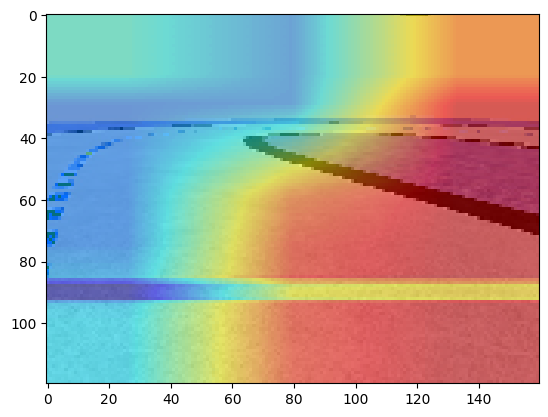

In [70]:
image = np.uint8(img[:, :, ::-1] * 255.0) 
cam = cv2.resize(cam[0], (img_arr.shape[1], img_arr.shape[0]))
cam = cam / np.max(cam)
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
cam = np.float32(heatmap) + np.float32(image)
cam = 255 * cam / (np.max(cam) + 1E-5)
cam = np.uint8(cam)
plt.imshow(cam)
plt.show()

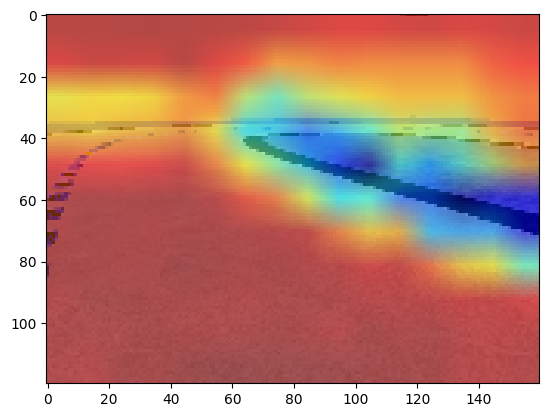

In [53]:
# Compute the mean of the output array over the channel dimension.

im_h, im_w = img.shape[:2]
image = np.uint8(img[:, :, ::-1] * 255.0)
# image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
channel_mean = np.mean(output, axis=3)
heatmap = channel_mean[0]  # img 0

# Normalize the heatmap (optional)
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Apply a color map (e.g., 'jet')
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
result = cv2.addWeighted(image, 0.4, heatmap, 0.6, 0)

# # Display the colored 2D array.
plt.imshow(result)
plt.show()

In [31]:
# plt.imshow(img)

In [32]:
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

In [33]:
# plt.imshow(rgb2gray(img))

In [ ]:
def visualize_gradcam_discrete_ppo(
    sess,
    rgb_img,
    sensor='FRONT_FACING_CAMERA',
    category_index=0,
    num_of_actions=5
):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions
    @return: overlayed heatmap
    '''

    img_arr = np.array(rgb_img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)

    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x: [img_arr]}

    # Get the policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])

    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))

    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    print("Custom Print: ", cams.shape, output.shape, weights.shape)

    # im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0]  # img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0)  # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h))  # zoom heatmap
    cam = np.maximum(cam, 0)  # relu clip
    heatmap = cam / np.max(cam)  # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)  # grayscale to color
    cam = np.float32(cam) + np.float32(image)  # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5)  # Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1]  # to RGB

    return cam


In [16]:
def visualize_gradcam_discrete_ppo(
    sess,
    rgb_img,
    sensor='FRONT_FACING_CAMERA',
    category_index=0,
    num_of_actions=5
):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions
    @return: overlayed heatmap
    '''

    img_arr = np.array(rgb_img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)

    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x: [img_arr]}

    # Get the policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])

    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))

    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    print("Custom Print: ", cams.shape, output.shape, weights.shape)

    # im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0]  # img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0)  # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h))  # zoom heatmap
    cam = np.maximum(cam, 0)  # relu clip
    heatmap = cam / np.max(cam)  # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)  # grayscale to color
    cam = np.float32(cam) + np.float32(image)  # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5)  # Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1]  # to RGB

    return cam


In [17]:
heatmaps = []
view_models = models_file_path[0:1]
for model_file in view_models:
    model, obs, model_out = load_session(model_file, my_sensor)
    arr = []
    for f in picture_files[0:1]:
        img = cv2.imread(f)
        img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
        heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(action_names))
        heatmaps.append(heatmap)    

    tf.reset_default_graph()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



2023-10-24 18:46:23.343602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:46:23.343677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:46:23.343699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:46:23.344109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:46:23.344136: I tensorflow/core/co

load graph: ../models/rogue-2018W-C12-1-3-DC-MM-FINAL-NYC-COPY-2-model/agent/model.pb

main_level/agent/main/online/network_1/mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/add: (Add): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/strided_slice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/bias/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy: (Softmax): /job:localhost/rep

nv2d_0/BiasAdd_1: (BiasAdd): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-24 18:46:23.544291: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/BatchnormActivationDropout_1_activation_1: (Relu): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-24 18:46:23.544294: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/kernel/read_1: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-24 18:46:23.544296: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/bias/read_1: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-24 18:46:23.544299: I tensorflow/core/common_runtime/placer.cc:125] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/Conv2D_1: (Conv2D): /job:localhost/replica:0/task:0/device:GPU:0
2023-10-24 18:46:23.544302: I tensorflow/core/common_run

nline/network_1/StopGradient_1: (StopGradient): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/mul_2: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/mul_1/y_1: (Pack): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/mul_1_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/add_1: (Add): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/strided_slice_1: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/kernel/read_1: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/bias/read_1: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device

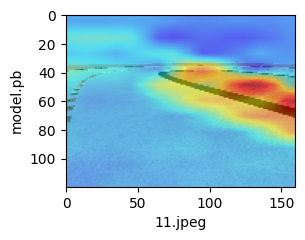

In [109]:
fig, ax = plt.subplots(len(view_models),len(picture_files),
                       figsize=(7*len(view_models),2.5*len(picture_files)), sharex=True, sharey=True, squeeze=False)

for i in list(range(len(view_models))):
    plt.setp(ax[i, 0], ylabel=os.path.basename(view_models[i]))
    for j in list(range(len(picture_files))):
        ax[i][j].imshow(heatmaps[i * len(picture_files) + j])
        plt.setp(ax[-1:, j], xlabel=os.path.basename(picture_files[j]))
plt.tight_layout()    
plt.show()

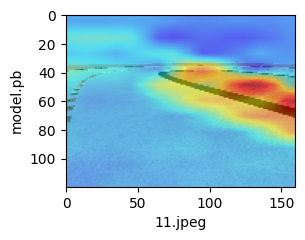

2023-10-24 17:33:38.616061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 17:33:38.616070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1977] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-10-24 17:33:38.616100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 17:33:38.616116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3413 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-10-24 17:33:38.747706: I tensorflow/c

onst): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/kernel: (Const): /job:localhost/replica:0/task:0/device:GPU:0
main_level/agent/main/online/network_1/ppo_head_0/policy_fc/bias: (Const): /job:localhost/replica:0/task:0/device:GPU:0
one_hot/on_value: (Const): /job:localhost/replica:0/task:0/device:GPU:0
one_hot/off_value: (Const): /job:localhost/replica:0/task:0/device:GPU:0
one_hot/indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
one_hot/depth: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/grad_ys_0/Const: (Const): /job:localhost/replica:0

In [87]:
fig, ax = plt.subplots(len(view_models),len(picture_files),
                       figsize=(7*len(view_models),2.5*len(picture_files)), sharex=True, sharey=True, squeeze=False)

for i in list(range(len(view_models))):
    plt.setp(ax[i, 0], ylabel=os.path.basename(view_models[i]))
    for j in list(range(len(picture_files))):
        ax[i][j].imshow(heatmaps[i * len(picture_files) + j])
        plt.setp(ax[-1:, j], xlabel=os.path.basename(picture_files[j]))
plt.tight_layout()    
plt.show()